In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/loanprediction/test_lAUu6dG.csv
/kaggle/input/loanprediction/train_ctrUa4K.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/loanprediction/train_ctrUa4K.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


We can see that there are missing values in LoanAmont, Loan_Amount_term and Credit_History

Now lets see for categorical value

In [5]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Distribution Analysis

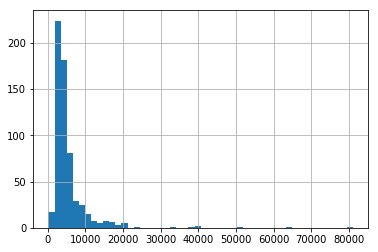

In [6]:
df['ApplicantIncome'].hist(bins=50)

Here we can see some extreme values.

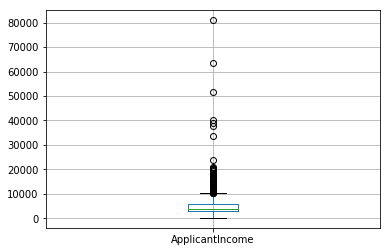

In [7]:
df.boxplot(column='ApplicantIncome')

It can be clearly seen that there are so many outliers for applicant income. May be it is related to education, so let us segregate applicant income with respect to education.

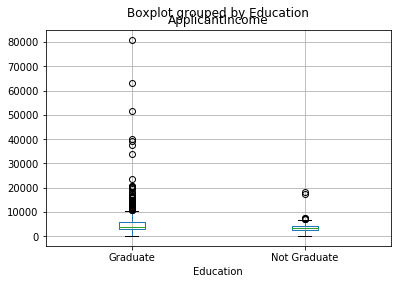

In [8]:
df.boxplot(column='ApplicantIncome', by = 'Education')

There is no difference between mean incomes of graduates and non gradutes. There are higher number of graduates with very high incomes, appearing to be the outliers.

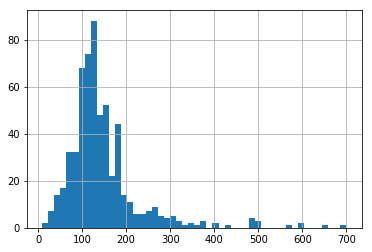

In [9]:
df['LoanAmount'].hist(bins=50)

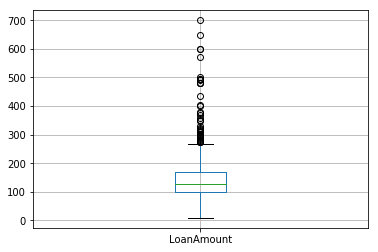

In [10]:
df.boxplot(column='LoanAmount')

Here, too we can see many outliers. Both Applicant Income and Loan Amount require data mugging. Loan Amount has missing values too.

In [11]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan for each Credit History class:')
print (temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


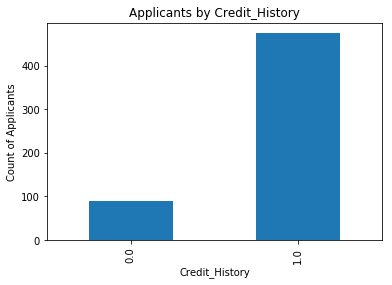

In [12]:
import matplotlib.pyplot as plt
plt.xlabel('Credit_History')
plt.ylabel('Count of Applicants')
plt.title("Applicants by Credit_History")
temp1.plot(kind='bar')

Text(0.5, 1.0, 'Probability of getting loan by credit history')

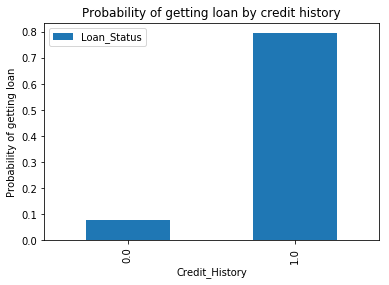

In [13]:
temp2.plot(kind = 'bar')
plt.xlabel('Credit_History')
plt.ylabel('Probability of getting loan')
plt.title("Probability of getting loan by credit history")

For Married and UnMarried People

In [14]:
temp1 = df['Married'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Married'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan on the basis of martial status:')
print (temp2)

Frequency Table for Credit History:
No     213
Yes    398
Name: Married, dtype: int64

Probility of getting loan on the basis of martial status:
         Loan_Status
Married             
No          0.629108
Yes         0.716080


On the basis of Employment

In [15]:
temp1 = df['Self_Employed'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Self_Employed'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan on the basis of employment:')
print (temp2)

Frequency Table for Credit History:
Yes     82
No     500
Name: Self_Employed, dtype: int64

Probility of getting loan on the basis of employment:
               Loan_Status
Self_Employed             
No                0.686000
Yes               0.682927


On the Basis of Property Area

In [16]:
temp1 = df['Property_Area'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Property_Area'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Credit History:') 
print (temp1)

print ('\nProbility of getting loan on the basis of employment:')
print (temp2)

Frequency Table for Credit History:
Rural        179
Urban        202
Semiurban    233
Name: Property_Area, dtype: int64

Probility of getting loan on the basis of employment:
               Loan_Status
Property_Area             
Rural             0.614525
Semiurban         0.768240
Urban             0.658416


We could also combine this plot in to one in a stacked chart.

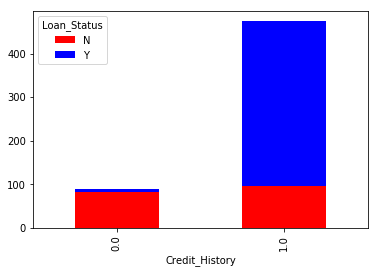

In [17]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

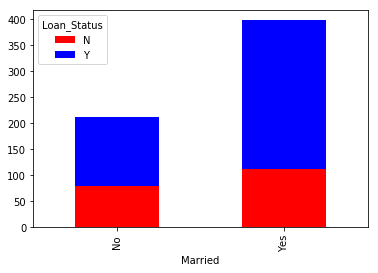

In [18]:
temp3 = pd.crosstab(df['Married'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

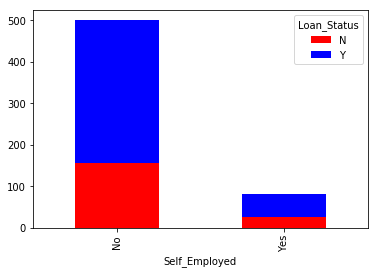

In [19]:
temp3 = pd.crosstab(df['Self_Employed'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

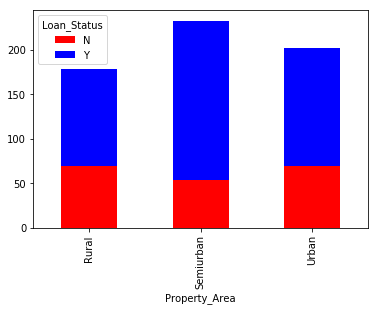

In [20]:
temp3 = pd.crosstab(df['Property_Area'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

Now lets check the missing values in the dataset

In [21]:
df.apply(lambda x : sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [23]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

As you can see 532 people are not self employed which is quite large when compared to employed people, so we fill the missing values with 'No'

In [24]:
df['Self_Employed'].fillna('No', inplace=True)

Before moving to fill the other missing values lets treat the extreme values in LoanAmount and Applicant Income

Instead of treating the extreme values as outliers lets try a log transformation to nullify their effect

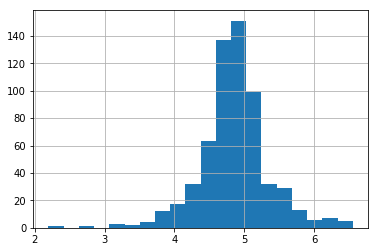

In [25]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

So coming to Applicant Income, we shall combine it with Co-aaplicants as the people with lower income have strong co-applicants.

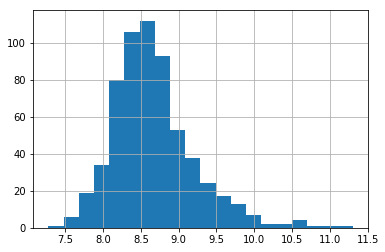

In [26]:
df['TotalIncome']=df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20)

Filling The Remaining Missing Values

In [27]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [28]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [29]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
#   kf = KFold(data.shape[0], n_folds=5)
  kf = KFold( n_splits = 5)
  kf.get_n_splits(data.values)

  error = []
  for train, test in kf.split(data.values):
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

# Logistic Regression

We can use all the features but it may lead to overfitting.

So, we shall use only those features which will give a high chance of getting loan.

In [30]:
outcome_var = ['Loan_Status']
model = LogisticRegression()
predictor_var = ['Credit_History']
# print( type(df.values), df)
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

In [31]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

# Decision Tree
Decision tree is another method for making a predictive model. It is known to provide higher accuracy than logistic regression model. Read more about Decision Trees.

In [32]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


Let’s try a few numerical variables:

In [33]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 89.414%
Cross-Validation Score : 68.722%


Here we observed that although the accuracy went up on adding variables, the cross-validation error went down. This is the result of model over-fitting the data. Let’s try an even more sophisticated algorithm and see if it helps:

# Random Forest
An advantage with Random Forest is that we can make it work with all the features and it returns a feature importance matrix which can be used to select features.

In [34]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy : 100.000%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Cross-Validation Score : 78.669%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Here we see that the accuracy is 100% for the training set. This is the ultimate case of overfitting and can be resolved in two ways:

Reducing the number of predictors
Tuning the model parameters

Let’s try both of these. First we see the feature importance matrix from which we’ll take the most important features.

In [35]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.271876
TotalIncome_log     0.263508
LoanAmount_log      0.228400
Dependents          0.051246
Property_Area       0.049020
Loan_Amount_Term    0.041207
Married             0.024933
Gender              0.023647
Education           0.023412
Self_Employed       0.022752
dtype: float64


Let’s use the top 5 variables for creating a model. Also, we will modify the parameters of random forest model a little bit:

In [36]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy : 83.062%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed whe

Cross-Validation Score : 80.461%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Notice that although accuracy reduced, but the cross-validation score is improving showing that the model is generalizing well. Remember that random forest models are not exactly repeatable. Different runs will result in slight variations because of randomization. But the output should stay in the ballpark.

Thank You